<a href="https://colab.research.google.com/github/rliu7926/weinstein-ligo-research/blob/main/4.6%20Sky%20Location%20Calculations.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
! pip install -q 'PyCBC==1.15.3' 'lalsuite==6.66'
! pip install astropy
! pip install sympy
! pip install pynverse

from astropy.cosmology import FlatLambdaCDM, Planck18, z_at_value
import astropy
import numpy as np
from numpy import diff 
import pylab
import math
import progressbar

import astropy.units as u
import matplotlib.pyplot as plt
import scipy.integrate as integrate
from numpy import trapz
from pynverse import inversefunc

from pycbc import waveform
from pycbc.waveform import get_td_waveform, get_fd_waveform

import pycbc
import pycbc.noise
import pycbc.psd

from random import randint
from pycbc.filter import matched_filter
from pycbc.psd import interpolate, inverse_spectrum_truncation

import pandas as pd
from pycbc.types import TimeSeries

import seaborn as sns
from matplotlib.colors import LogNorm, Normalize
from matplotlib.ticker import MaxNLocator
import time

     |████████████████████████████████| 3.1 MB 8.7 MB/s 
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
    Preparing wheel metadata ... done
     |████████████████████████████████| 28.5 MB 73 kB/s 
     |████████████████████████████████| 1.0 MB 41.3 MB/s 
     |████████████████████████████████| 75 kB 6.6 MB/s 
     |████████████████████████████████| 52 kB 1.7 MB/s 
     |████████████████████████████████| 1.6 MB 43.1 MB/s 
     |████████████████████████████████| 54 kB 3.5 MB/s 
     |████████████████████████████████| 3.2 MB 44.2 MB/s 
  Created wheel for pynverse: filename=pynverse-0.1.4.4-py3-none-any.whl size=6363 sha256=d608ffb1821146541d74e5f4bbcd4a46e1f77818ac3740d7facba5a1b0c9362a
  Stored in directory: /root/.cache/pip/wheels/06/eb/74/006b76fdd8229ed3767fef546c825c2924f1def2d023929d9d
Successfully built pynverse


In [ ]:
## Waveform time-domain frequency, with celestial coordinates added

def create_waveform(mass1=30, mass2=30, spin1=[0, 0, 0], spin2=[0, 0, 0], inclination=0, long_asc_nodes=0, resolution=1.0/1024, frequencybound=20, distance=500, cosmology=Planck18, approximant="IMRPhenomPv2"):

  redshift = 1 + z_at_value(cosmology.comoving_distance, distance * u.Mpc)
  lum_dist = cosmology.luminosity_distance(redshift-1)
  fbound = frequencybound * redshift

  waveform, waveform_cross = get_td_waveform(approximant=approximant,
                                             mass1=mass1, mass2=mass2,
                                             spin1x=spin1[0], spin1y=spin1[1], spin1z=spin1[2],
                                             spin2x=spin2[0], spin2y=spin2[1], spin2z=spin2[2],
                                             inclination=inclination, long_asc_nodes=long_asc_nodes,
                                             delta_t=resolution/redshift,
                                             f_lower=fbound)
  
  waveform_amplitude = [0.0] * len(waveform)
  waveform_time = [0.0] * len(waveform)

  for i in range(len(waveform)):
    waveform_amplitude[i] = waveform[i]
    waveform_time[i] = waveform.sample_times[i]

  waveform_amplitude = [i/lum_dist for i in waveform_amplitude]
  waveform_time = [i*redshift for i in waveform_time]

  waveform_amplitude = np.array(waveform_amplitude)
  waveform_time = np.array(waveform_time)

  return waveform_amplitude, waveform_time

In [ ]:
## Waveform frequency-domain frequency, with celestial coordinates added

def create_fd_waveform(mass1, mass2, spin1, spin2, inc, asc, fres, flow, dist, cosmology=Planck18, approximant="IMRPhenomPv2"):

  redshift = 1 + z_at_value(cosmology.comoving_distance, dist * u.Mpc)
  lum_dist = cosmology.luminosity_distance(redshift-1)
  flow_bound = flow * redshift

  hplus, hcross = get_fd_waveform(approximant=approximant,
                                  mass1=mass1, mass2=mass2,
                                  spin1x=spin1[0], spin1y=spin1[1], spin1z=spin1[2],
                                  spin2x=spin2[0], spin2y=spin2[1], spin2z=spin2[2],
                                  inclination=inc, long_asc_nodes=asc, 
                                  delta_f=fres * redshift,
                                  f_lower=flow_bound)
  
  freq_value = hplus.sample_frequencies / redshift
  freq_amp = hplus / lum_dist * redshift

  return freq_amp, freq_value


In [ ]:
## Expectation value function, updated with new parameters

def expectation_SNR(mass1, mass2, spin1, spin2, tmass1, tmass2, tspin1, tspin2, inc, asc, tinc, tasc, res, fres, flow, dist, tdist, psd, cosmology=Planck18, approximant="IMRPhenomPv2"):

  ## Create waveform and template

  gw_amp, gw_value = create_fd_waveform(mass1=mass1, mass2=mass2, spin1=spin1, spin2=spin2, inc=inc, asc=asc, fres=fres, flow=flow, dist=dist, approximant=approximant)
  signal_amp, signal_value = create_fd_waveform(mass1=tmass1, mass2=tmass2, spin1=tspin1, spin2=tspin2, inc=tinc, asc=tasc, fres=fres, flow=flow, dist=tdist, approximant=approximant)

  gwfreq = pycbc.types.frequencyseries.FrequencySeries(initial_array=gw_amp, delta_f=fres)
  signalfreq = pycbc.types.frequencyseries.FrequencySeries(initial_array=signal_amp, delta_f=fres)

  ## Create PSD 

  flen = len(gw_value)

  if psd == 'aLIGOAPlusDesignSensitivityT1800042':
    psdfreq = pycbc.psd.aLIGOAPlusDesignSensitivityT1800042(flen, fres, flow)
  
  if psd == 'aLIGODesignSensitivityP1200087':
    psdfreq = pycbc.psd.aLIGODesignSensitivityP1200087(flen, fres, flow)

  if psd == 'CosmicExplorerP1600143':
    psdfreq = pycbc.psd.CosmicExplorerP1600143(flen, fres, flow)
    

  ## Calculate SNR

  gwdata = gwfreq + psdfreq
  snr = matched_filter(template=signalfreq, data=gwdata, psd=psdfreq, low_frequency_cutoff=flow)

  print("The signal-to-noise ratio is: {}".format(max(abs(snr))))

  return(max(abs(snr)))
  

In [ ]:
## Distance estimation function, updated with new parameters

def estimate_distance(snr, guess, alpha, iterations, tolerance, mass1, mass2, spin1, spin2, tmass1, tmass2, tspin1, tspin2, inc, asc, tinc, tasc, res, fres, flow, dist='param', psd='aLIGODesignSensitivityP1200087', cosmology=Planck18, approximant='IMRPhenomPv2'): 
  
  if dist == 'param':
    pred = guess
    estimate = expectation_SNR(mass1, mass2, spin1, spin2, tmass1, tmass2, tspin1, tspin2, inc, asc, tinc, tasc, res, fres, flow, guess, guess, psd, cosmology, approximant)
    print("Initial guess: {}".format(estimate))

    diff = 1
    iter = 0

    while iter < iterations and abs(diff) > tolerance:
      diff = snr - estimate
      pred = pred + alpha * diff
      estimate = expectation_SNR(mass1, mass2, spin1, spin2, tmass1, tmass2, tspin1, tspin2, inc, asc, tinc, tasc, res, fres, flow, pred, pred, psd, cosmology, approximant)
      iter = iter + 1
      print("Iteration {}: Estimate {}, Distance {}".format(iter, estimate, pred))
    
  else: 
    print("Nothing to estimate: distance needs to be set to param")

  print("Final estimate: {}, off by {}".format(pred, diff))
  return(pred, diff) 

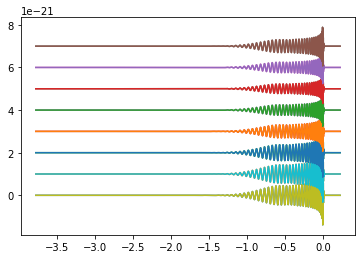

In [ ]:
## Visualize impact of difference in declination 

hp0, time = create_waveform(inclination=0)
hp1, time = create_waveform(inclination=0.1*np.pi)
hp2, time = create_waveform(inclination=0.2*np.pi)
hp3, time = create_waveform(inclination=0.3*np.pi)
hp4, time = create_waveform(inclination=0.4*np.pi)
hp5, time = create_waveform(inclination=0.5*np.pi)
hp6, time = create_waveform(inclination=0.6*np.pi)
hp7, time = create_waveform(inclination=0.7*np.pi)

models = [hp0, hp1, hp2, hp3, hp4, hp5, hp6, hp7]
for i in range(len(models)):
  pylab.plot(time, models[i]+i*10**-21)

# Waveform amplitude is minimized at declination = pi/2 rad

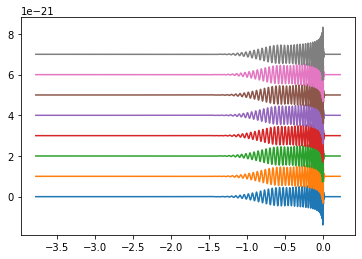

In [ ]:
## Visualize impact of difference in right ascension 

hp0, time = create_waveform(long_asc_nodes=0)
hp1, time = create_waveform(long_asc_nodes=0.2*np.pi)
hp2, time = create_waveform(long_asc_nodes=0.4*np.pi)
hp3, time = create_waveform(long_asc_nodes=0.6*np.pi)
hp4, time = create_waveform(long_asc_nodes=0.8*np.pi)
hp5, time = create_waveform(long_asc_nodes=1.0*np.pi)
hp6, time = create_waveform(long_asc_nodes=1.2*np.pi)
hp7, time = create_waveform(long_asc_nodes=1.4*np.pi)

models = [hp0, hp1, hp2, hp3, hp4, hp5, hp6, hp7]
for i in range(len(models)):
  pylab.plot(time, models[i]+i*10**-21)

# Waveform amplitude is not impacted

In [ ]:
## Expectation SNR at different declinations and right ascensions 

decs = np.arange(0, 1, 0.04)*np.pi
ascs = np.arange(0, 2, 0.1)*np.pi

expectation = np.zeros((len(decs), len(ascs)))

for i in range(len(decs)):
  for j in range(len(ascs)):
    expectation[i][j] = expectation_SNR(mass1=30, mass2=30, spin1=[0,0,0], spin2=[0,0,0],
                                        tmass1=30, tmass2=30, tspin1=[0,0,0], tspin2=[0,0,0],
                                        inc=decs[i], asc=ascs[j], tinc=decs[i], tasc=ascs[j],
                                        res=1.0/1024, fres=1.0/16, flow=20, dist=1000, tdist=1000, psd='aLIGODesignSensitivityP1200087')


Text(51.0, 0.5, 'Right Ascension ($\\pi$ rad.)')

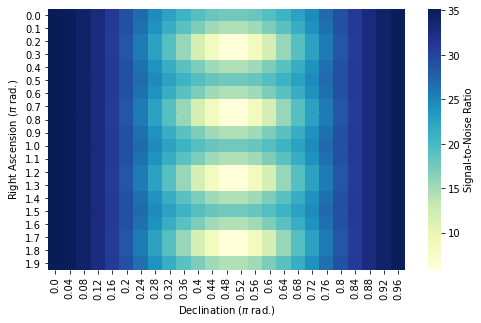

In [ ]:
decs = np.around(np.arange(0, 1, 0.04), decimals=2)
ascs = np.around(np.arange(0, 2, 0.1), decimals=2)

fig = plt.figure(figsize=(8,4.8))

heatmap = pd.DataFrame(expectation.T, columns=decs, index=ascs)
pos = fig.add_subplot(111)
sns.heatmap(heatmap, ax=pos, linewidths=0, cmap="YlGnBu", cbar_kws={'label': 'Signal-to-Noise Ratio'})

pos.set_xlabel('Declination ($\pi$ rad.)')
pos.set_ylabel('Right Ascension ($\pi$ rad.)')

In [ ]:
## Calculate antenna volume as a function of distance/redshift

def pdet(x):
  a2 = 0.374222
  a4 = 2.04216
  a8 = -2.63948
  alpha = 1.0
  return a2*(1-x/alpha)**2 + a4*(1-x/alpha)**4 + a8*(1-x/alpha)**8 + (1-a2-a4-a8)*(1-x/alpha)**10

def antenna_vol(dist):
  z = z_at_value(Planck18.comoving_distance, dist * u.Mpc)
  
  bins = np.linspace(0, z, 100)
  integrand = [0] * len(bins)
  
  for i in range(len(integrand)):
    ratio = Planck18.luminosity_distance(bins[i])/Planck18.luminosity_distance(z)
    integrand[i] = 1/(1+bins[i]) * Planck18.differential_comoving_volume(bins[i]).value * pdet(ratio)
  
  return 4*np.pi * trapz(y=integrand, x=bins)


dist = np.linspace(100, 13000, 500)
totalvolume, antennavolumes, zvals = ([0] * len(dist) for i in range(3))

for i in range(len(dist)):
  zvals[i] = z_at_value(Planck18.comoving_distance, dist[i] * u.Mpc)
  totalvolume[i] = Planck18.comoving_volume(zvals[i]).value
  antennavolumes[i] = antenna_vol(dist[i])


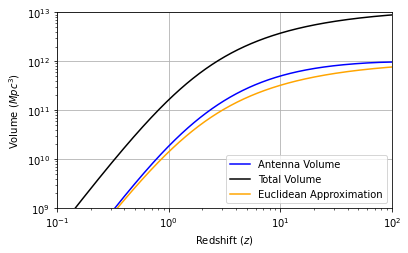

In [ ]:
fig = plt.figure(figsize=(6, 3.6))
plt.loglog(zvals, antennavolumes, color='blue')
plt.loglog(zvals, totalvolume, color='black')
plt.loglog(zvals, np.array(totalvolume)/11.605, color='orange')
plt.xlabel('Redshift ($z$)')
plt.ylabel('Volume ($Mpc^3$)')
plt.ylim(10**9, 10**13)
plt.xlim(0.1, 100)
plt.legend(labels=['Antenna Volume', 'Total Volume', 'Euclidean Approximation'])
pylab.grid()

In [ ]:
## Find formula to directly relate SNR to redshift and distance

zvals = np.linspace(0.1, 15, 150)
distances, lumdist, snr10, snr30, snr50 = ([0] * len(zvals) for i in range(5))

snr = [snr10, snr30, snr50]
masses = [10, 30, 50]

for i in range(len(zvals)):
  distances[i] = Planck18.comoving_distance(zvals[i]).value
  lumdist[i] = Planck18.luminosity_distance(zvals[i]).value
  for m in range(len(snr)):
    snr[m][i] = expectation_SNR(mass1=masses[m], mass2=masses[m], spin1=[0,0,0], spin2=[0,0,0],
                                tmass1=masses[m], tmass2=masses[m], tspin1=[0,0,0], tspin2=[0,0,0],
                                inc=0, asc=0, tinc=0, tasc=0, res=1.0/1024, fres=1.0/16, flow=20,
                                dist=distances[i], tdist=distances[i], psd='CosmicExplorerP1600143')
  print(i, distances[i])

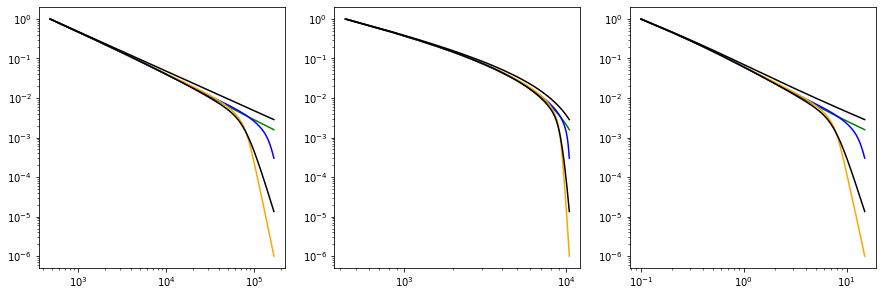

In [ ]:
fig = plt.figure(figsize=(15.0, 4.8))

fig.add_subplot(1,3,1)

pylab.loglog(lumdist, snr10/max(snr10), color='green')
pylab.loglog(lumdist, snr30/max(snr30), color='blue')
pylab.loglog(lumdist, snr50/max(snr50), color='orange')

inverse = [0] * len(lumdist)
for i in range(len(inverse)):
  inverse[i] = 1 / lumdist[i] * lumdist[0]

inversezvals = [0] * len(inverse)
for i in range(len(inverse)):
  inversezvals[i] = inverse[i] / ((zvals[i]/7)**7 + zvals[i]/7 + 1)

pylab.loglog(lumdist, inverse, color='black')
pylab.loglog(lumdist, inversezvals, color='black')

fig.add_subplot(1,3,2)

pylab.loglog(distances, snr10/max(snr10), color='green')
pylab.loglog(distances, snr30/max(snr30), color='blue')
pylab.loglog(distances, snr50/max(snr50), color='orange')
pylab.loglog(distances, inverse, color='black')
pylab.loglog(distances, inversezvals, color='black')

fig.add_subplot(1,3,3)

pylab.loglog(zvals, snr10/max(snr10), color='green')
pylab.loglog(zvals, snr30/max(snr30), color='blue')
pylab.loglog(zvals, snr50/max(snr50), color='orange')
pylab.loglog(zvals, inverse, color='black')
pylab.loglog(zvals, inversezvals, color='black')

Text(0, 0.5, 'SNR')

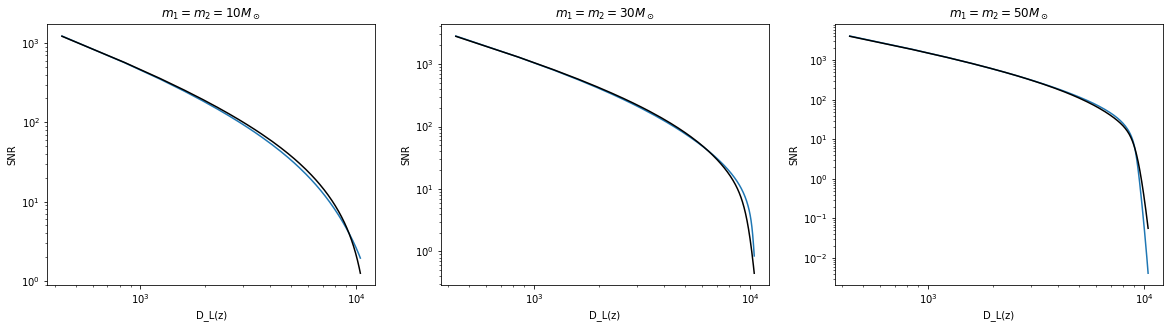

In [ ]:
fig = plt.figure(figsize=(20.0, 4.8))

rel10, rel30, rel50 = ([0] * len(lumdist) for i in range(3))
rels = [rel10, rel30, rel50]
snr = [snr10, snr30, snr50]

masses = [10, 30, 50]

def snrapprox(mass, zval, orig):
  lumdist = Planck18.luminosity_distance(zval).value
  inverse = orig / lumdist * 475.8222675121877
  zfactor = (np.sqrt(mass)*zval/50)**(np.sqrt(mass)) + (np.sqrt(mass)*zval/50) + 1
  approx = inverse / zfactor
  
  return approx

for i in range(len(rels)):
  for d in range(len(lumdist)):
    rels[i][d] = snrapprox(mass=masses[i], zval=zvals[d], orig=snr[i][0])


fig.add_subplot(1,3,1)

pylab.loglog(distances, snr10)
pylab.loglog(distances, rel10, color='black')
plt.title('$m_1 = m_2 = 10 M_\odot$')
plt.xlabel('D_L(z)')
plt.ylabel('SNR')

fig.add_subplot(1,3,2)

pylab.loglog(distances, snr30)
pylab.loglog(distances, rel30, color='black')
plt.title('$m_1 = m_2 = 30 M_\odot$')
plt.xlabel('D_L(z)')
plt.ylabel('SNR')

fig.add_subplot(1,3,3)

pylab.loglog(distances, snr50)
pylab.loglog(distances, rel50, color='black')
plt.title('$m_1 = m_2 = 50 M_\odot$')
plt.xlabel('D_L(z)')
plt.ylabel('SNR')

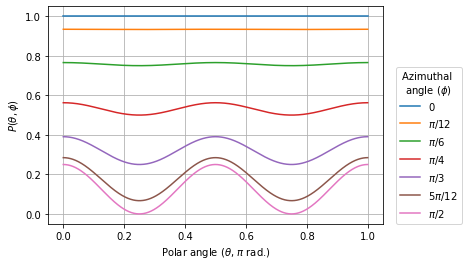

In [ ]:
## Calculate average boost in SNR needed

powerfunc = lambda y, x: (1/4 * (1 + (np.cos(x))**2)**2 * (np.cos(2*y))**2 + (np.cos(x) * np.sin(2*y))**2)

polar = np.linspace(0, np.pi, 1000)
power0, power15, power30, power45, power60, power75, power90 = ([0] * len(polar) for i in range(7))
power = [power0, power15, power30, power45, power60, power75, power90]
azimuthal = np.linspace(0, np.pi/2, 7)

for i in range(len(power)):
  for j in range(len(polar)):
    power[i][j] = powerfunc(polar[j], azimuthal[i])
  
  pylab.plot(polar/np.pi, power[i])

plt.grid()
plt.xlabel('Polar angle ($\\theta $, $\pi$ rad.)')
plt.ylabel('$P(\\theta , \phi)$')
plt.legend(labels=['0', '$\pi/12$', '$\pi/6$', '$\pi/4$', '$\pi/3$', '$5 \pi /12$', '$\pi/2$'], title='Azimuthal \n angle ($\phi$)', loc=[1.04, 0])

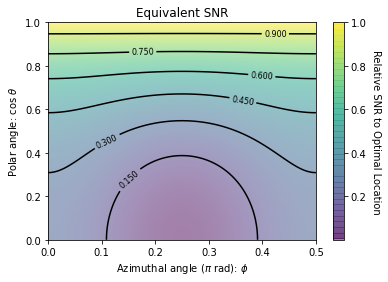

In [ ]:
## Create a grid of P(theta, phi) values

cospolar = np.linspace(0, 1, 100)
azimuthal = np.linspace(0, np.pi/2, 100)

polar = [0] * len(cospolar)
for i in range(len(polar)):
  polar[i] = np.arccos(cospolar[i])

pvals = np.zeros((len(polar), len(azimuthal)))

for i in range(len(polar)):
  for j in range(len(azimuthal)):
    pvals[i][j] = powerfunc(x=polar[i], y=azimuthal[j])

## Plot contour map

contours = plt.contour(azimuthal/np.pi, cospolar, pvals, 8, colors='black')
plt.clabel(contours, inline=True, fontsize=8)

plt.imshow(pvals, origin='lower', cmap='viridis', alpha=0.5, extent=[0, 0.5, 0, 1], aspect='auto')

plt.ylabel("Polar angle: $\cos \; \\theta$")
plt.xlabel("Azimuthal angle ($\pi$ rad): $\phi$")
plt.title("Equivalent SNR")

cbar = plt.colorbar()
cbar.set_label('Relative SNR to Optimal Location', rotation=270, labelpad=15)

The signal-to-noise ratio is: 28.397047529259666


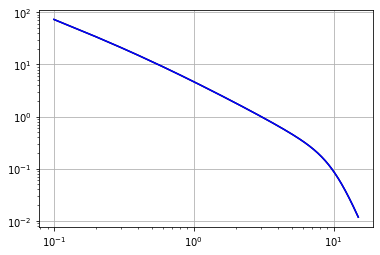

In [ ]:
def snrapprox(mass, zval, origsnr, origzval):

  origlumdist = Planck18.luminosity_distance(origzval).value
  newlumdist = Planck18.luminosity_distance(zval).value
  
  inverse = origsnr * origlumdist / newlumdist
  zfactor = (np.sqrt(mass)*zval/50)**(np.sqrt(mass)) + (np.sqrt(mass)*zval/50) + 1
  approx = inverse / zfactor

  return(approx)

## Inverse function for snrapprox

def snrapproxinv(mass, snr, origsnr, origzval, guess=1, iterations=150, tolerance=10**-5, alpha=0.05):

  pred = snrapprox(mass=mass, zval=guess, origsnr=origsnr, origzval=origzval)
  diff = snr - pred

  iter = 0

  while iter < iterations and abs(diff) > tolerance:
    guess = guess - alpha*diff * (guess/pred)
    pred = snrapprox(mass=mass, zval=guess, origsnr=origsnr, origzval=origzval)
    diff = snr - pred
    iter = iter + 1

  return(guess, diff)
  print("Desired SNR: {}, Predicted z-value: {}".format(snr, pred))

## Test snrapprox and snrapproxinv

snr30 = expectation_SNR(mass1=30, mass2=30, spin1=[0,0,0], spin2=[0,0,0],
                        tmass1=30, tmass2=30, tspin1=[0,0,0], tspin2=[0,0,0],
                        inc=0, asc=0, tinc=0, tasc=0, res=1.0/1024, fres=1.0/16,
                        flow=20, dist=1000, tdist=1000, psd='aLIGODesignSensitivityP1200087')

snr30dist = z_at_value(Planck18.comoving_distance, 1000 * u.Mpc)

zvals = np.linspace(0.1, 15, 150)
snr30approx = [0] * len(zvals)

for i in range(len(snr30approx)):
  snr30approx[i] = snrapprox(mass=30, zval=zvals[i], origsnr=snr30, origzval=snr30dist)

pylab.loglog(zvals, snr30approx, color='black')

invzvals = [0] * len(snr30approx)
for i in range(len(invzvals)):
  invzvals[i], diff = snrapproxinv(mass=30, snr=snr30approx[i], origsnr=snr30, origzval=snr30dist)

pylab.loglog(invzvals, np.array(snr30approx), color='blue')

plt.grid()

## Function works!

In [ ]:
## Run inverse approximation function over sky location bins

cospolar = np.linspace(0, 1, 20)
azimuthal = np.linspace(0, np.pi/2, 20)

polar = [0] * len(cospolar)
for i in range(len(polar)):
  polar[i] = np.arccos(cospolar[i])

pmult = np.zeros((len(polar), len(azimuthal)))

for i in range(len(polar)):
  for j in range(len(azimuthal)):
    pmult[i][j] = 8 / powerfunc(x=polar[i], y=azimuthal[j])

dist, diff = (np.zeros(pmult.shape) for i in range(2))

for i in range(dist.shape[0]):
  for j in range(dist.shape[1]):
    dist[i][j], diff[i][j] = snrapproxinv(mass=30, snr=pmult[i][j], origsnr=snr30, origzval=snr30dist, iterations=500)
    if dist[i][j] < 0:
      dist[i][j] = 0

## Total: 400 bins, Runtime: 16.5 sec

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: RuntimeWarning: invalid value encountered in double_scalars
  import sys
/usr/local/lib/python3.7/dist-packages/astropy/cosmology/core.py:1253: IntegrationWarning: The occurrence of roundoff error is detected, which prevents 
  the requested tolerance from being achieved.  The error may be 
  underestimated.
  args=self._inv_efunc_scalar_args)[0]


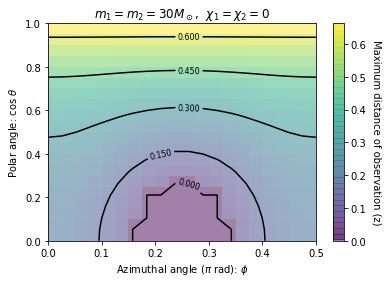

In [ ]:
## Plot contour map

contours = plt.contour(azimuthal/np.pi, cospolar, dist, 5, colors='black')
plt.clabel(contours, inline=True, fontsize=8)

plt.imshow(dist, origin='lower', cmap='viridis', alpha=0.5, extent=[0, 0.5, 0, 1], aspect='auto')

plt.ylabel("Polar angle: $\cos \; \\theta$")
plt.xlabel("Azimuthal angle ($\pi$ rad): $\phi$")
plt.title("$m_1 = m_2 = 30 M_\odot$,  $\chi_1 = \chi_2 = 0$")

cbar = plt.colorbar()
cbar.set_label("Maximum distance of observation (z)", rotation=270, labelpad=15)

In [ ]:
print(sum(sum(dist))/400)
print(dist[19][19]/(sum(sum(dist))/400))
print(dist[19][19])

0.3054323230451922
2.1698240431026963
0.6627343980841678
